# Annotating Cell Types

This workbook can be run after the standard workflow.
It is demonstrating how to use the  annotation function to annotate the dataset that was runned through the standard worflow.

In this notebook, we will show how to use in-besca annotation to assign cell type to clusters.
We focus on immune celltype and demonstrate signature-scoring functions.


An alternative in the case a an annotated training dataset already exists is to use the auto-annot module. Please refer to the corresponding tutorial.

In [1]:
import besca as bc
import numpy as np
import pandas as pd
import scanpy.api as sc
import matplotlib.pyplot as plt
from scipy import sparse, io
import os
import time
import logging
import seaborn as sns
sc.logging.print_versions()

# for standard processing, set verbosity to minimum
sc.settings.verbosity = 0  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80)
version = '2.8'
start0 = time.time()

/pstore/home/julienla/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
/pstore/home/julienla/.local/lib/python3.7/site-packages/scanpy/api/__init__.py:6: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning,


scanpy==1.4.6 anndata==0.7.1 umap==0.4.2 numpy==1.17.0 scipy==1.4.1 pandas==1.0.3 scikit-learn==0.23.0 statsmodels==0.11.1 python-igraph==0.8.2


In [2]:
#define standardized filepaths based on above input
root_path = os.getcwd()
bescapath=os.path.split(root_path)[0]

### Uncomment this when running after the standard workflow
#analysis_name = 'standard_workflow_besca2.0'
#results_folder = os.path.join(root_path, 'analyzed', analysis_name)
#clusters='leiden'

### Use this for testing, on data provided with besca
analysis_name='pbmc3k_processed'
results_folder = os.path.split(os.getcwd())[0] + '/besca/datasets/data/'
clusters='louvain'#'leiden'



#root_path='6.6k_healthy_pbmc_storage_effects_inhouse/' ### replace this with the path to this dataset
#analysis_name='standard_workflow_2_8_batch_corrected'
#results_folder = os.path.join(root_path, 'analyzed', analysis_name)


The chunk of code below is usefull if this is the initial installation of besca and that you are running this notebook as a test. It will download if needed the test datasets and export the labelling. 
This export is usually done at the end of the standard workflow. Exported files  are necessary for the annotations.

In [3]:
testing = True
if testing:
# This line will either download, or load the datasets
    adata = bc.datasets.pbmc3k_processed()## THIS SHOULD BE FIX SOON the format is not correct.
    adata.X = sparse.csr_matrix( adata.X.copy())
    adata.raw.var['SYMBOL'] = adata.raw.var.index
    
    adata = bc.st.additional_labeling(adata, labeling_to_use= clusters, labeling_name = clusters, 
                                      labeling_description = 'Exporting a postori the labels for annotation',
                                      labeling_author = 'Testing', 
                                      results_folder= results_folder)

rank genes per label calculated using method wilcoxon.
mapping of cells to  louvain exported successfully to cell2labels.tsv
average.gct exported successfully to file
fract_pos.gct exported successfully to file
labelinfo.tsv successfully written out
./datasets/data/labelings/louvain/WilxRank.gct written out
./datasets/data/labelings/louvain/WilxRank.pvalues.gct written out
./datasets/data/labelings/louvain/WilxRank.logFC.gct written out


In [4]:

adata = sc.read_h5ad(os.path.join(results_folder, analysis_name + '.h5ad') )


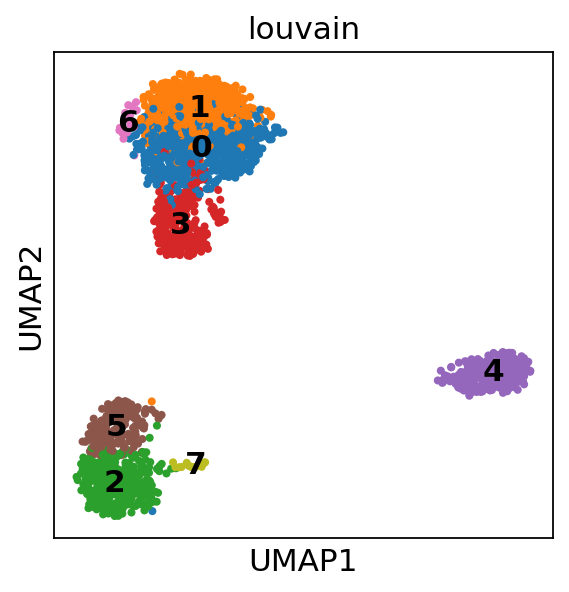

In [5]:
sc.pl.umap(adata, color= [clusters], legend_loc='on data')

In [6]:
# One can load besca-provided signatures using the function below
signature_dict = bc.datasets.load_immune_signatures(refined=False)

signature_dict

{'lymphocyte': ['PTPRC'],
 'myeloid': ['S100A8', 'S100A9', 'CST3'],
 'Bcell': ['CD19', 'CD79A', 'MS4A1'],
 'Tcells': ['CD3E', 'CD3G', 'CD3D'],
 'CD4': ['CD4'],
 'CD8': ['CD8A', 'CD8B'],
 'NKcell': ['NKG7', 'GNLY', 'NCAM1'],
 'monocyte': ['CST3', 'CSF1R', 'ITGAM', 'CD14', 'FCGR3A', 'FCGR3B'],
 'macrophage': ['CD14',
  'IL1B',
  'LYZ    CD163   ITGAX',
  'CD68',
  'CSF1R',
  'FCGR3A']}

Additionaly it is possible to read an compute scanpy score using this function below.

If the gmt file is composed of combined signature (UP and DN), a common score will be computed: 
$$Total\_SCORE= Score_{UP} - Score_{DN}$$

In [7]:

gmt_file= bescapath + '/besca/datasets/genesets/Immune.gmt'
bc.tl.sig.combined_signature_score(adata, gmt_file,
                             UP_suffix='_UP', DN_suffix='_DN', method='scanpy',
                             overwrite=False, verbose=False,
                             use_raw=True, conversion=None)

In [8]:
scores = [x for x in adata.obs.columns if 'scanpy' in x]

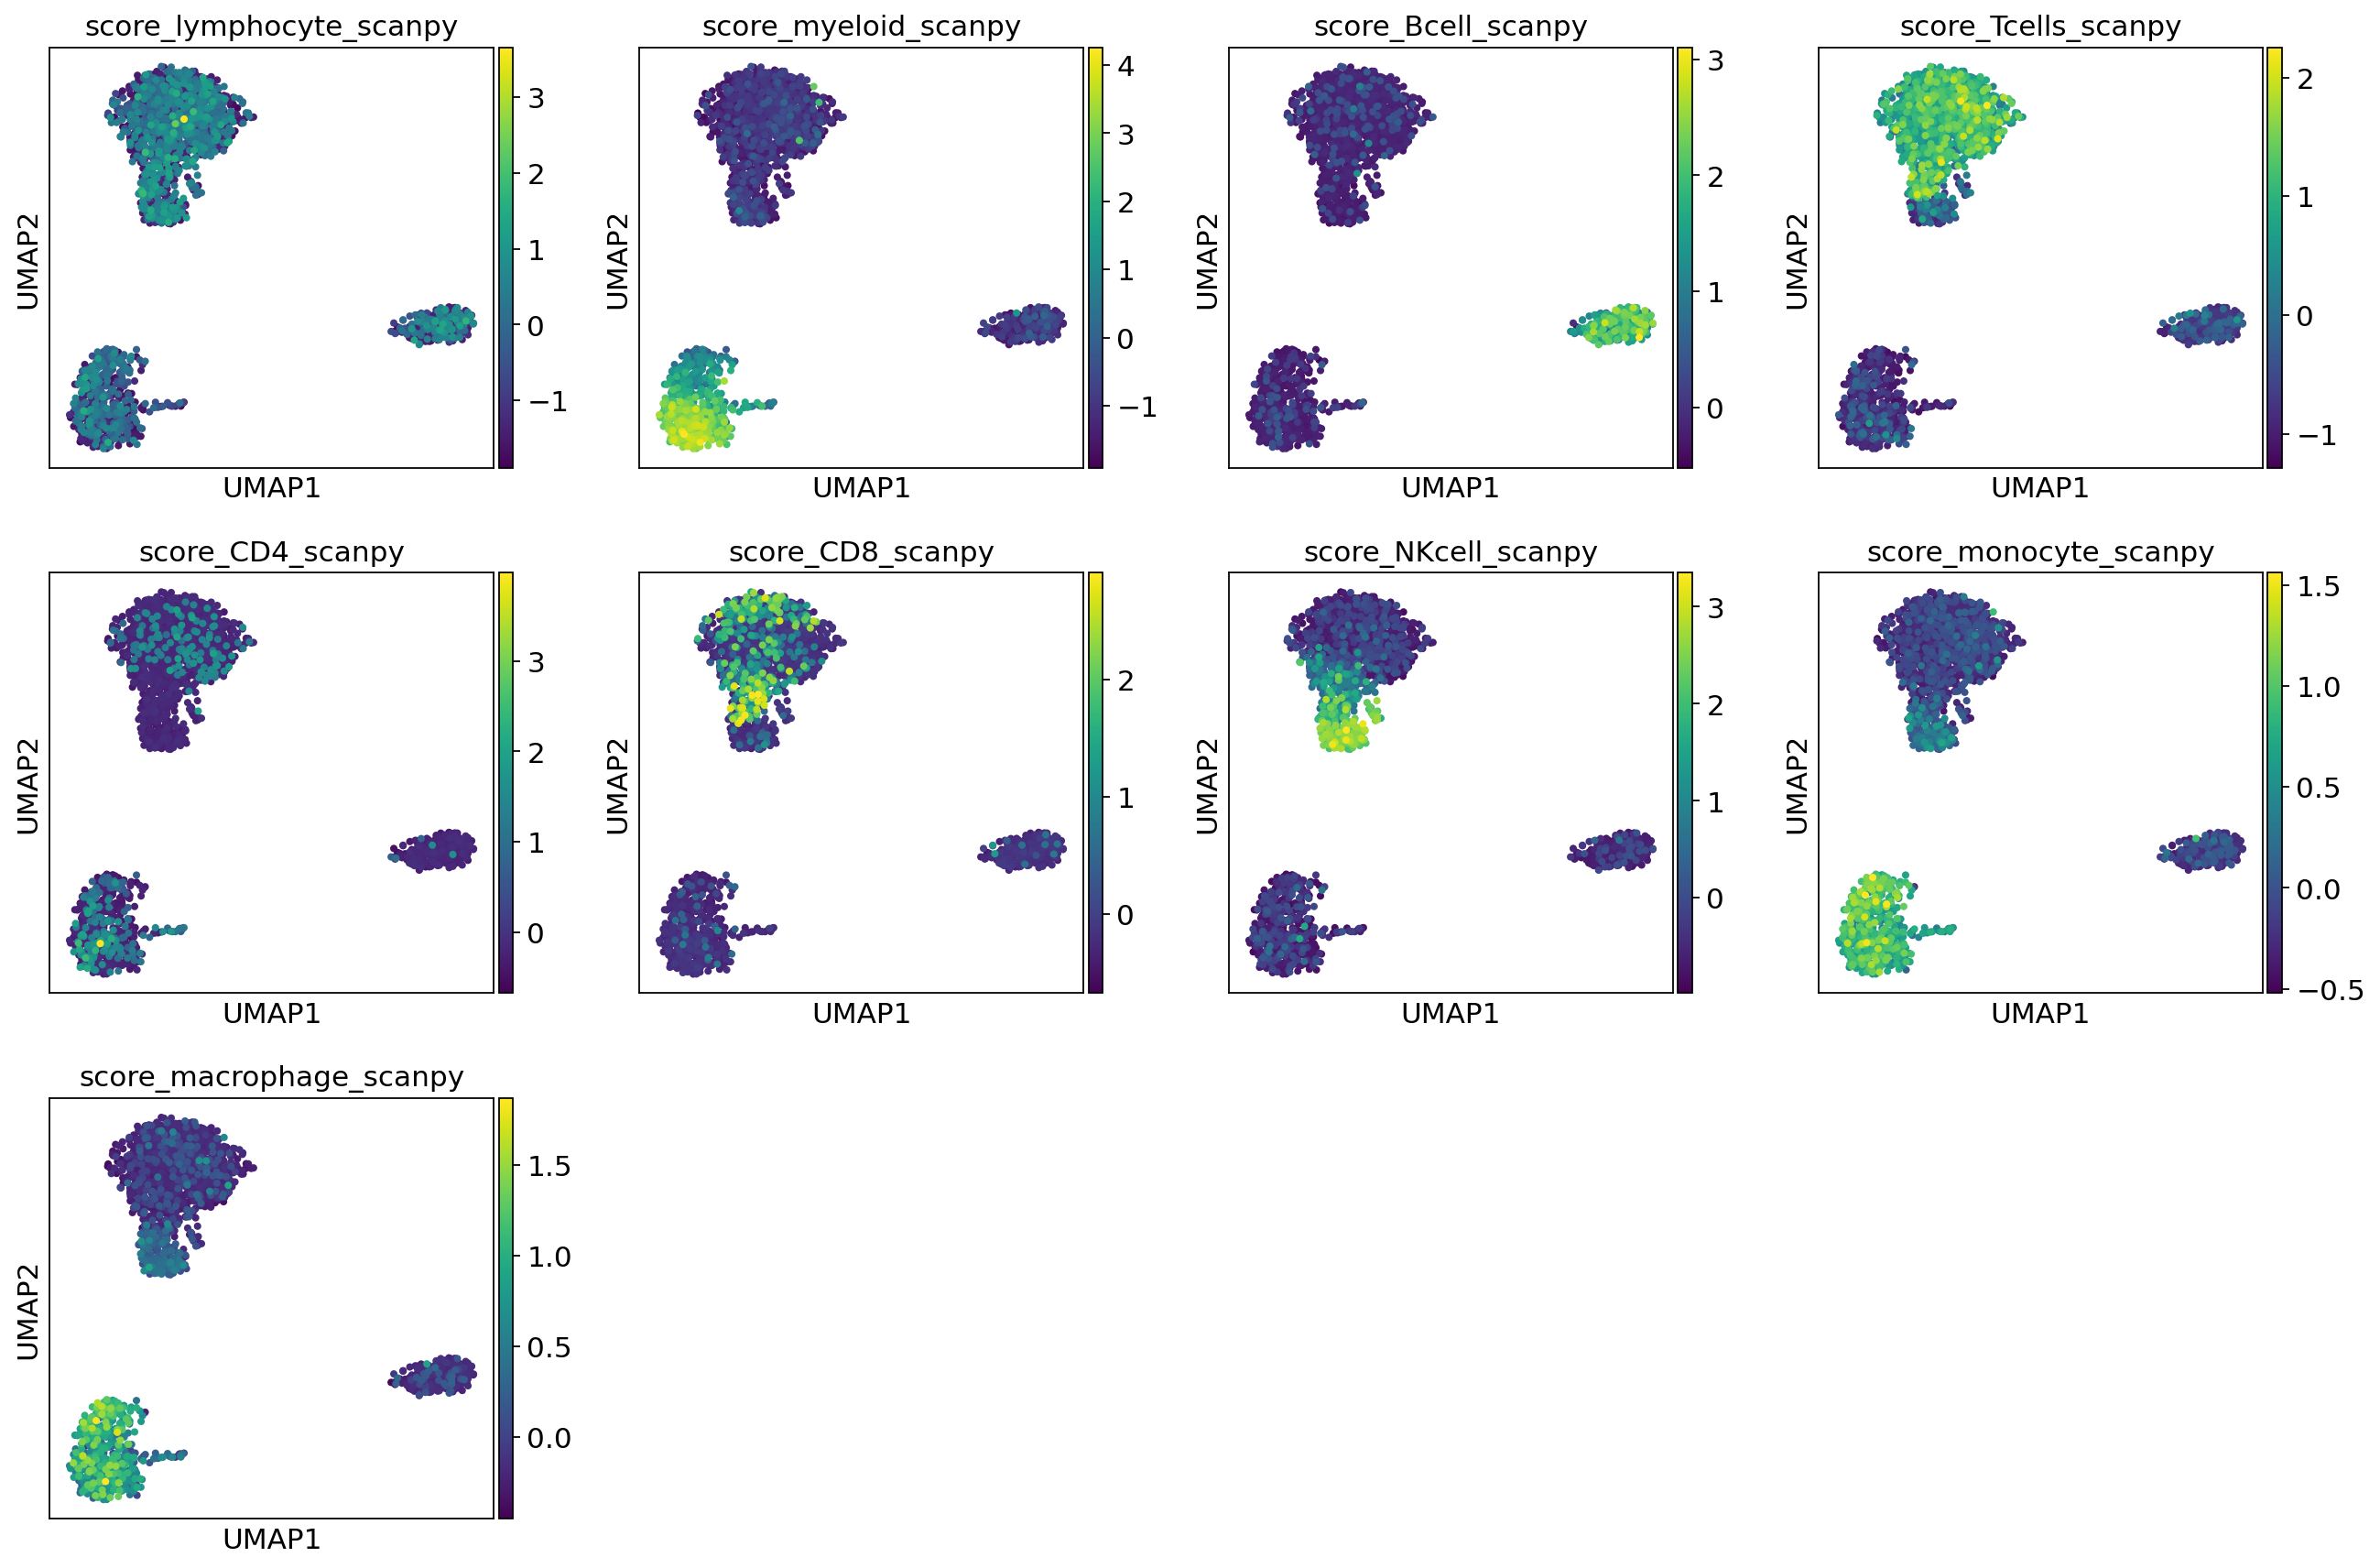

In [9]:
sc.pl.umap(adata, color= scores)

# Immune signatures for specific sub-populations

In [10]:
 ## PROVIDED WITH BESCA
gmt_file_anno= bescapath + '/besca/datasets/genesets/CellNames_scseqCMs6_sigs.gmt'
bc.tl.sig.combined_signature_score(adata, gmt_file_anno)


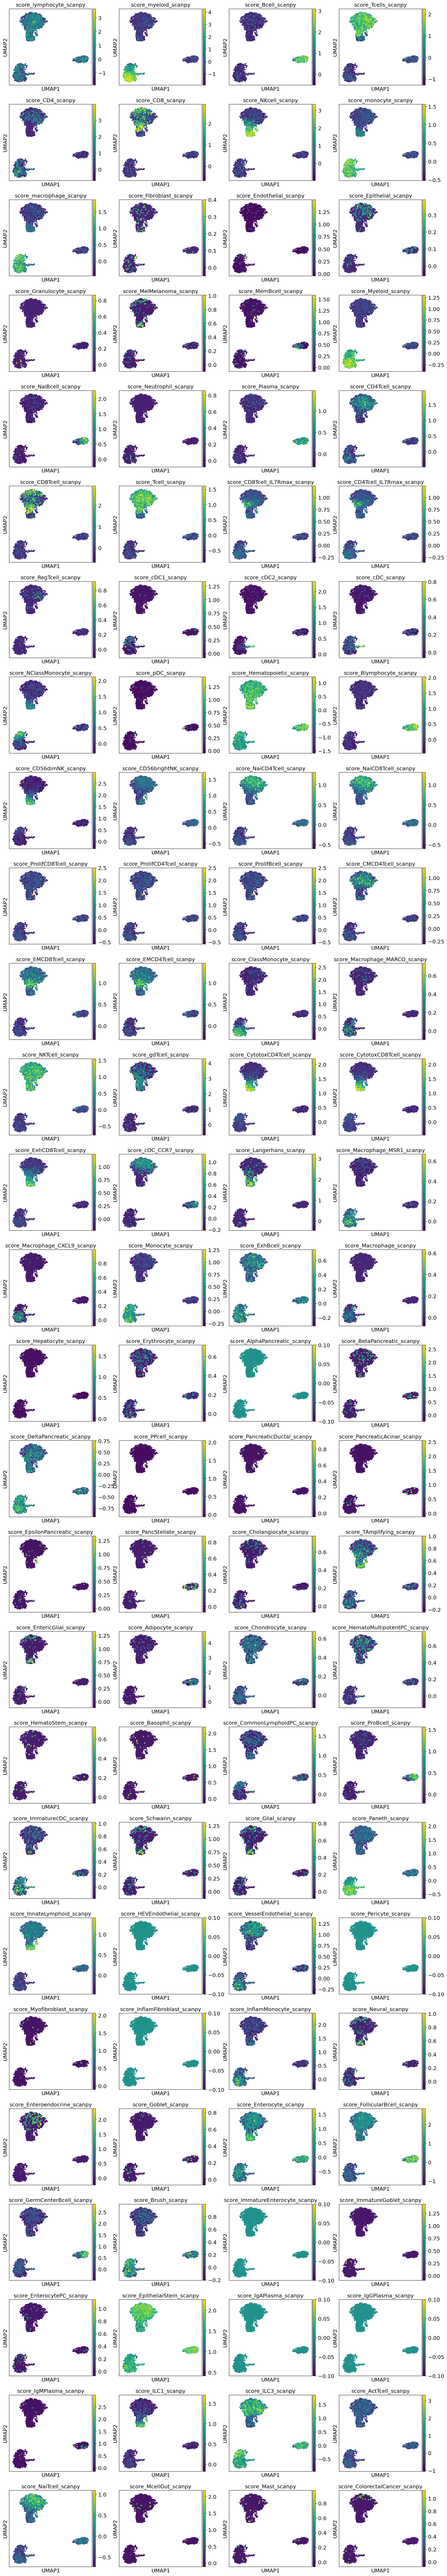

In [11]:
scores = [x for x in adata.obs.columns if 'scanpy' in x]
sc.pl.umap(adata, color= scores, color_map = 'viridis')

# Automated annotation

A decision-tree-based annotation that reads signatures from a provided .gmt file and hierarchy as well as cutoffs and signature ordering from a configuration file and attributes each cell to a specific type according to signature enrichment. 

This is an aid to start ther annotation and annotation can then be further refined by adding further signatures or adjusting the configuration files. It was tested mainly on PBMCs and oncology (tumor biopsies) related samples.


In [12]:
mymarkers = bc.tl.sig.read_GMT_sign(gmt_file_anno,directed=False)
mymarkers = bc.tl.sig.filter_siggenes(adata, mymarkers) ### remove genes not present in dataset or empty signatures
mymarkers['Ubi'] = ['B2M','ACTB', 'GAPDH'] ### used for cutoff adjustment to individual dataset, can be modified

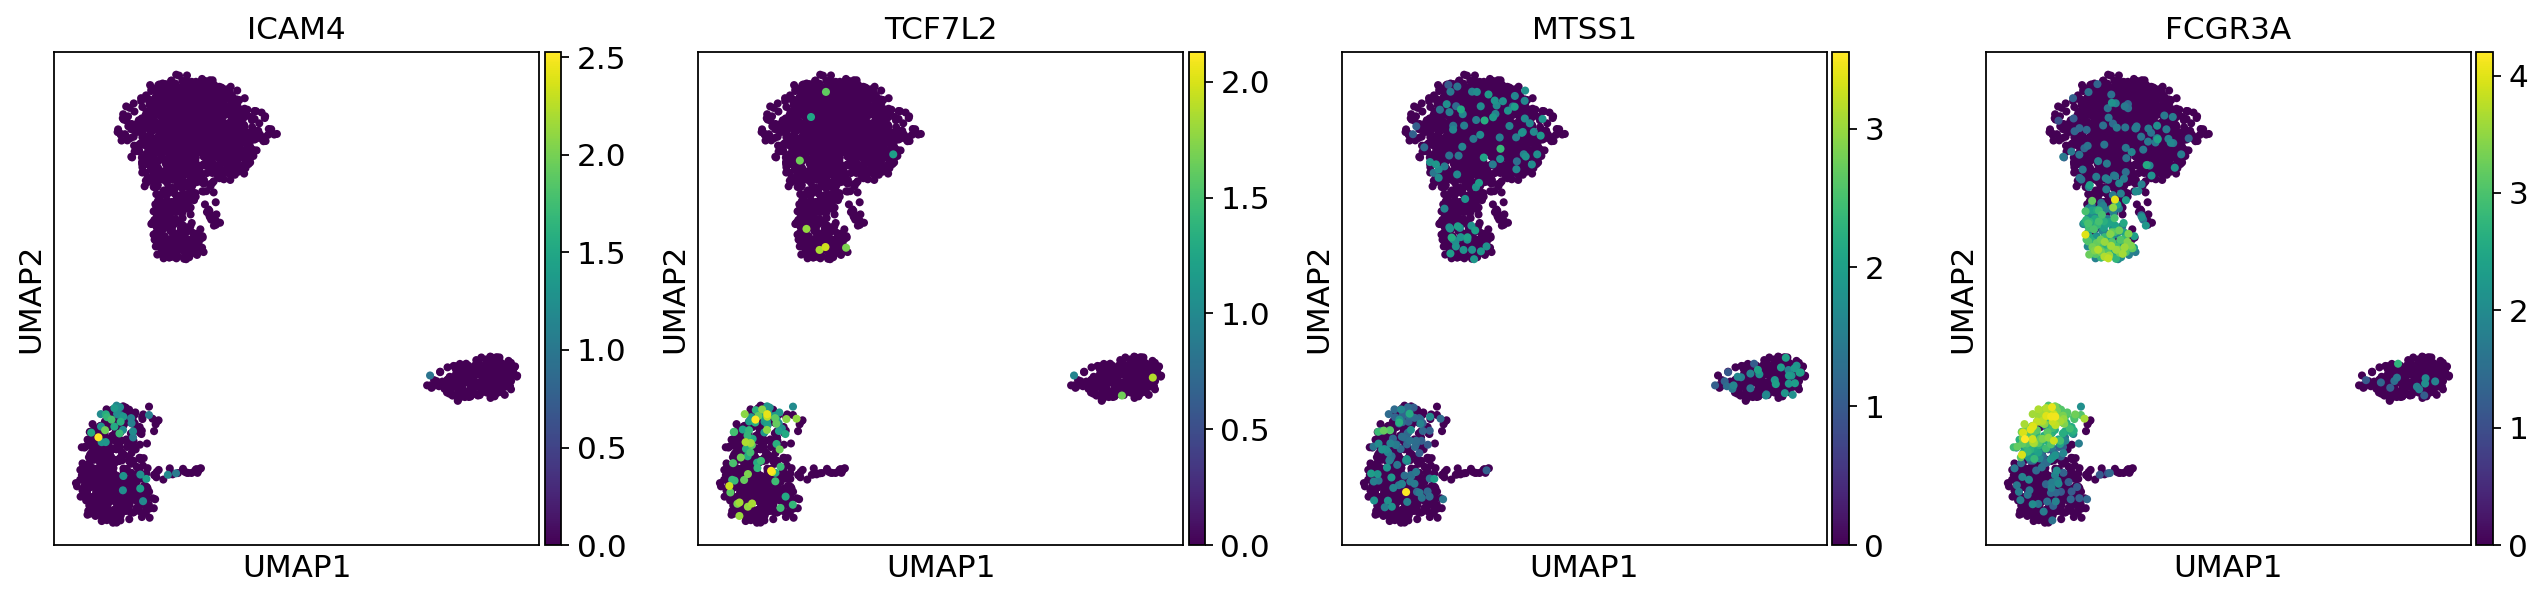

In [13]:
sc.pl.umap(adata, color= mymarkers['NClassMonocyte'])

We read the configuration file, containing hierarchy, cutoff and signature priority information. 
A new version of this file should be created and maintained with each annotation. 
The included example is optimised for the annotation of the 6.6k PBMC dataset. 

In [14]:
configfile=bescapath + '/besca/datasets/genesets/CellNames_scseqCMs6_config.tsv' ### replace this with your config

In [15]:
sigconfig,levsk=bc.tl.sig.read_annotconfig(configfile)

Fract_pos was exported by BESCA in the standard worflow test, 
contains information of fraction positive cells per genes per cluster.

We use these values as a basis for a wilcoxon test per signature per cluster. 

In [16]:

f=pd.read_csv(results_folder + "/labelings/"+clusters+"/fract_pos.gct",sep="\t",skiprows=2)
df=bc.tl.sig.score_mw(f,mymarkers)
myc=np.median(df.loc['Ubi',:]*0.5) ### Set a cutoff based on Ubi and scale with values from config file


In [17]:
df.iloc[0:3,0:7]

7         5         1         2         3         0  \
Bcell         11.8984   8.33839   6.37979   4.76838   3.33679   2.49939   
Fibroblast   0.714239  0.820929  0.292773  0.329242  0.711252  0.202773   
Endothelial   4.90864   4.45827  0.145811  0.294836  0.297302  0.099346   

                    4  
Bcell         67.9825  
Fibroblast   0.118098  
Endothelial  0.116622

For each signature, positive and negative clusters are determined. Only positive clusters are maintained. Cutoffs can be individualised based on the config file (scaling factor) and myc, which is determined based on ubiquitously expressed genes. 

In [18]:
#Cluster attribution based on cutoff
df=df.drop('Ubi')
sigscores={}
for mysig in list(df.index):
    sigscores[mysig]=bc.tl.sig.getset(df,mysig,sigconfig.loc[mysig,'Cutoff']*myc)
    #sigscores[mysig]=bc.tl.sig.getset(df,mysig,10)

One can inspect the cluster attribution per cell type in the signature list and adjust cutoffs as required. 

In [19]:
sigscores

{'Bcell': {'4'},
 'Fibroblast': set(),
 'Endothelial': set(),
 'Epithelial': set(),
 'Granulocyte': set(),
 'MelMelanoma': set(),
 'MemBcell': set(),
 'Myeloid': {'1', '2', '4', '5', '7'},
 'NKcell': {'3'},
 'NaiBcell': {'4'},
 'Neutrophil': set(),
 'Plasma': set(),
 'CD4Tcell': {'0', '1', '2', '3', '4', '5', '6'},
 'CD8Tcell': {'0', '1', '3', '6'},
 'Tcell': {'0', '1', '3', '6'},
 'CD8Tcell_IL7Rmax': set(),
 'CD4Tcell_IL7Rmax': set(),
 'RegTcell': set(),
 'cDC1': set(),
 'cDC2': {'7'},
 'cDC': {'7'},
 'NClassMonocyte': {'5'},
 'pDC': set(),
 'Hematopoietic': {'0', '1', '2', '3', '4', '5', '6', '7'},
 'Blymphocyte': {'4'},
 'CD56dimNK': {'3'},
 'CD56brightNK': set(),
 'NaiCD4Tcell': {'1'},
 'NaiCD8Tcell': {'1'},
 'ProlifCD8Tcell': set(),
 'ProlifCD4Tcell': set(),
 'ProlifBcell': set(),
 'CMCD4Tcell': {'0', '1', '6'},
 'EMCD8Tcell': {'0', '3', '6'},
 'EMCD4Tcell': {'0', '3', '6'},
 'ClassMonocyte': {'2'},
 'Macrophage_MARCO': set(),
 'NKTcell': {'0', '1', '3', '6'},
 'CytotoxCD4Tcell': 

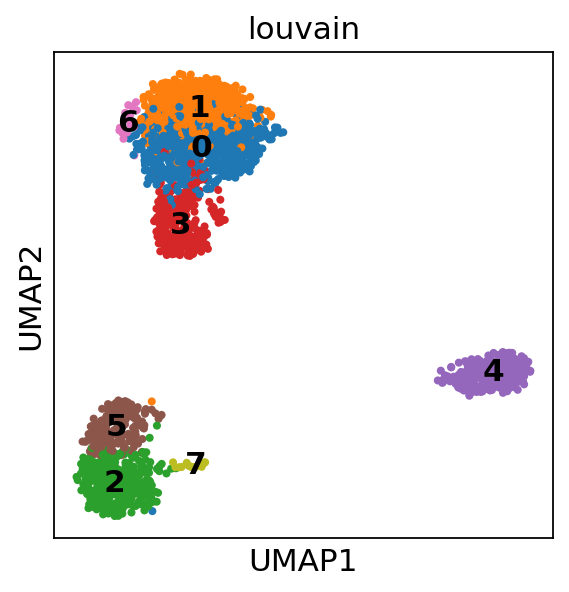

In [20]:
sc.pl.umap(adata, color= [clusters], legend_loc='on data')

Now each cluster gets annotated, according to the distinct levels specified in the config file. 
Note that in case a cluster is positive for multiple identities, only the first one is taken, 
in the order specified in the "Order" column in the config file. 

To check the given order, per levels, you can inspect levsk

In [21]:
levsk

[['Fibroblast',
  'Endothelial',
  'Epithelial',
  'Erythrocyte',
  'HematoStem',
  'Hepatocyte',
  'MelMelanoma',
  'Neural',
  'Adipocyte',
  'Hematopoietic',
  'Schwann',
  'Chondrocyte',
  'Glial',
  'ColorectalCancer'],
 ['Pericyte',
  'Blymphocyte',
  'Tcell',
  'CommonLymphoidPC',
  'Myeloid',
  'NKcell',
  'Enteroendocrine',
  'PancreaticAcinar',
  'ImmatureEnterocyte',
  'ImmatureGoblet',
  'EnterocytePC',
  'McellGut',
  'PancreaticDuctal',
  'PancStellate',
  'Cholangiocyte',
  'TAmplifying',
  'EntericGlial',
  'Enterocyte',
  'Goblet',
  'Paneth',
  'Brush',
  'HematoMultipotentPC',
  'InnateLymphoid',
  'HEVEndothelial',
  'VesselEndothelial',
  'Myofibroblast',
  'InflamFibroblast',
  'EpithelialStem'],
 ['Bcell',
  'ProBcell',
  'CD8Tcell',
  'CD4Tcell',
  'Granulocyte',
  'cDC',
  'ClassMonocyte',
  'pDC',
  'Plasma',
  'CD56dimNK',
  'CD56brightNK',
  'Macrophage',
  'gdTcell',
  'NClassMonocyte',
  'NKTcell',
  'Mast',
  'PPcell',
  'BetaPancreatic',
  'AlphaPancreat

In [22]:
cnames=bc.tl.sig.make_anno(df,sigscores,sigconfig,levsk)

We now obtained per each cluster cell type attribution at distinct levels. 

In [23]:
cnames

celltype0    celltype1       celltype2        celltype3
7  Hematopoietic      Myeloid             cDC             cDC2
5  Hematopoietic      Myeloid  NClassMonocyte   NClassMonocyte
1  Hematopoietic        Tcell        CD8Tcell      NaiCD8Tcell
2  Hematopoietic      Myeloid   ClassMonocyte    ClassMonocyte
3  Hematopoietic        Tcell        CD8Tcell  CytotoxCD8Tcell
0  Hematopoietic        Tcell        CD8Tcell       EMCD8Tcell
4  Hematopoietic  Blymphocyte           Bcell         NaiBcell
6  Hematopoietic        Tcell        CD8Tcell       EMCD8Tcell

Only short names were used in the signature naming convention in this case. 
One can easity tranform this to EFO terms if preferred, a conversion table comes with besca. 

This nomenclature is quite extended, and the function 
**obtain_dblabel** can perform the conversion.

In [24]:
### transform these short forms to dblabel - EFO standard nomenclature
cnamesDBlabel = bc.tl.sig.obtain_dblabel(bescapath+'/besca/datasets/nomenclature/CellTypes_v1.tsv', cnames )
cnamesDBlabel

celltype0                celltype1  \
7  hematopoietic cell        myeloid leukocyte   
5  hematopoietic cell        myeloid leukocyte   
1  hematopoietic cell                   T cell   
2  hematopoietic cell        myeloid leukocyte   
3  hematopoietic cell                   T cell   
0  hematopoietic cell                   T cell   
4  hematopoietic cell  lymphocyte of B lineage   
6  hematopoietic cell                   T cell   

                         celltype2  \
7           myeloid dendritic cell   
5           non-classical monocyte   
1  CD8-positive, alpha-beta T cell   
2               classical monocyte   
3  CD8-positive, alpha-beta T cell   
0  CD8-positive, alpha-beta T cell   
4                           B cell   
6  CD8-positive, alpha-beta T cell   

                                           celltype3  
7               CD1c-positive myeloid dendritic cell  
5                             non-classical monocyte  
1  naive thymus-derived CD8-positive, alpha-beta ...  
2                                 classical monocyte  
3          CD8-positive, alpha-beta cytotoxic T cell  
0    effector memory CD8-positive, alpha-beta T cell  
4                                       naive B cell  
6    effector memory CD8-positive, alpha-beta T cell

Finally, one can add the new labels to adata.obs as annotation. 

In [25]:
adata.obs['celltype0']=bc.tl.sig.add_anno(adata,cnamesDBlabel,'celltype0',clusters)
adata.obs['celltype2']=bc.tl.sig.add_anno(adata,cnamesDBlabel,'celltype2',clusters)
adata.obs['celltype3']=bc.tl.sig.add_anno(adata,cnamesDBlabel,'celltype3',clusters)

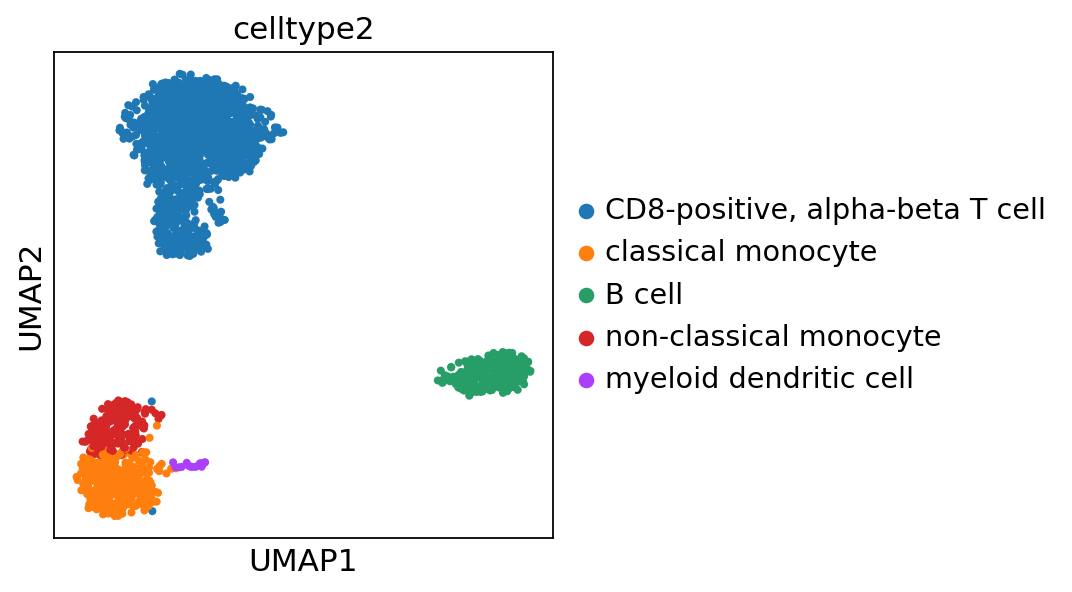

In [26]:
sc.pl.umap(adata,color=['celltype2']) #,'celltype3'

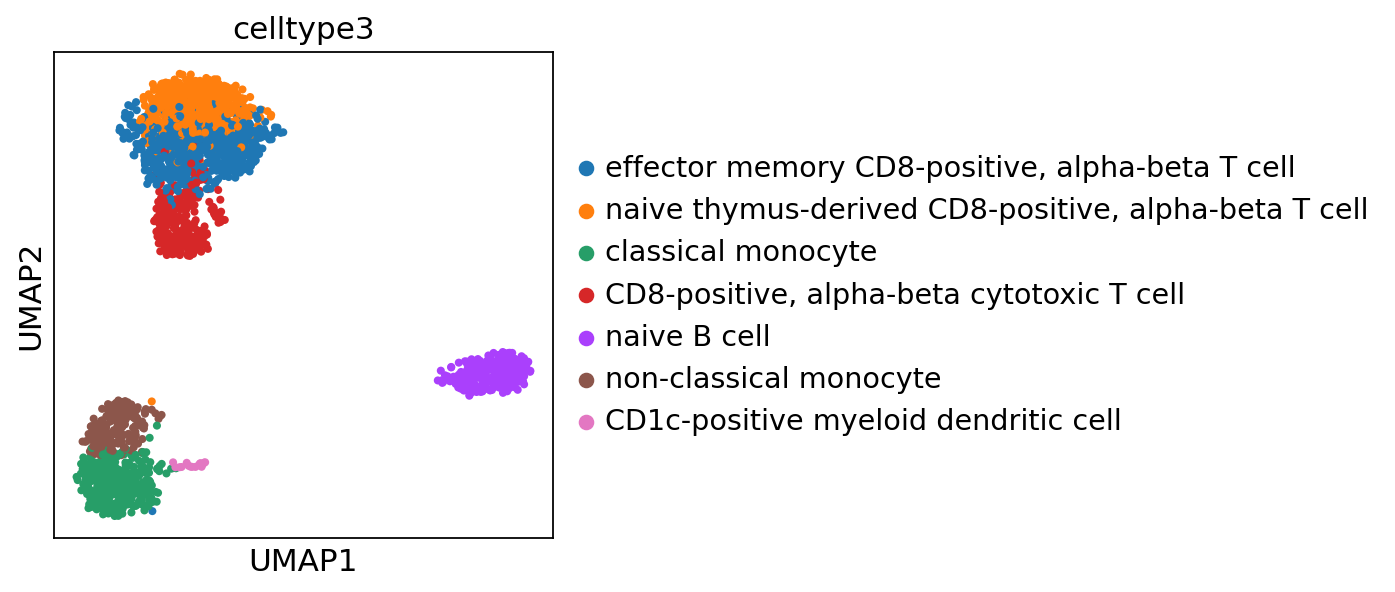

In [27]:
sc.pl.umap(adata,color=['celltype3']) #,'celltype3'

### Export labelling

Chosen labels can also be exported as a new folder in labelings/

In [28]:
### Save labelling
adata = bc.st.additional_labeling(adata, 'celltype3', 'celltype3', 'Major cell types attributed based on HumanCD45p_scseqCMs8', 'schwalip', results_folder)


rank genes per label calculated using method wilcoxon.
mapping of cells to  celltype3 exported successfully to cell2labels.tsv
average.gct exported successfully to file
fract_pos.gct exported successfully to file
labelinfo.tsv successfully written out
./datasets/data/labelings/celltype3/WilxRank.gct written out
./datasets/data/labelings/celltype3/WilxRank.pvalues.gct written out
./datasets/data/labelings/celltype3/WilxRank.logFC.gct written out
